# 洗錢
- 筆記: https://www.notion.so/jayschsu/c6a6219dd004469bbbfbecfb6d9883f3

In [39]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import pandas as pd
import numpy as np 

from log import init_logging
from data import Data
from model import Model

pd.set_option('display.max_rows', 500)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data
- Raw Data
    - custinfo_df, ccba_df, cdtx_df, dp_df, remit_df, 
    - tr_alertX_df, tr_sarY_df, public_alertX_df
    - custinfo_valid
- Featuring (Date)
    - cdtxDate_df, dpDate_df, remitDate_df
- Featuring (Accumulate)
    - cdtx_feature, dp_feature, remit_feature
- Featuring (Intergrated)
    - data_df
    - Feature_Dict
- Sar Flag
    - moneyLundry dataset (sar_flag==1, in alert_date)
    - falseAlarm dataset (sar_flag==0, in alert_date)
    - public dataset (sar_flag==2, in alert_date)

In [25]:
dataset = Data()
model = Model(dataset)

2022-10-31 10:44:20,600 INFO: func:init_data: 2.98 sec (utils.py:16)
2022-10-31 10:44:20,601 INFO: custinfo_preprocess (data.py:52)
invalid_data_qty: 2
2022-10-31 10:44:20,703 INFO: func:custinfo_preprocess: 0.10 sec (utils.py:16)
2022-10-31 10:44:20,704 INFO: featuring_alertDate (data.py:81)
2022-10-31 10:44:50,206 INFO: func:featuring_alertDate: 29.50 sec (utils.py:16)
2022-10-31 10:44:50,208 INFO: featuring_accumulate (data.py:147)
2022-10-31 10:45:30,352 INFO: func:featuring_accumulate: 40.14 sec (utils.py:16)
2022-10-31 10:45:30,354 INFO: featuring_integrate (data.py:162)
2022-10-31 10:45:52,089 INFO: func:featuring_integrate: 21.74 sec (utils.py:16)


## MODEL

In [222]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 3)

In [131]:
dataset.data_df['sar_flag'].value_counts()

0.0    23451
2.0     1770
1.0      233
Name: sar_flag, dtype: int64

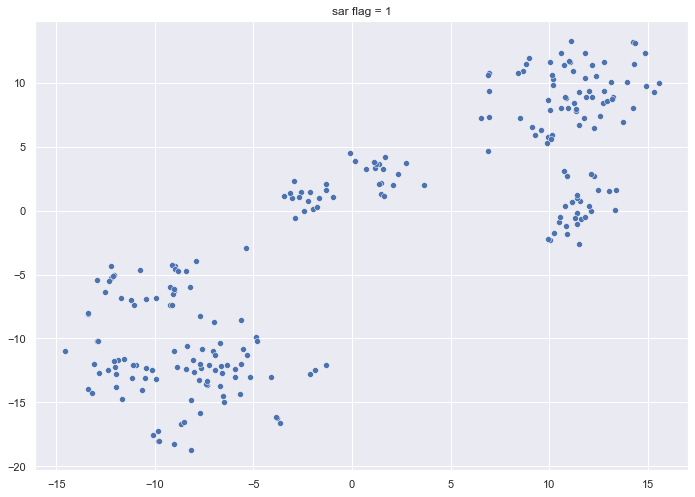

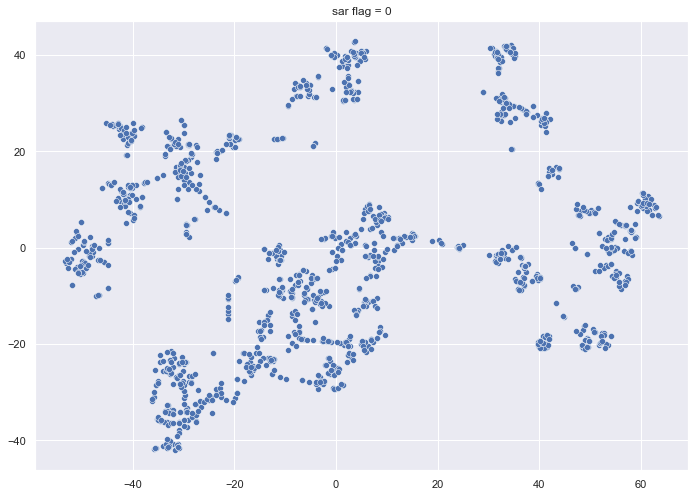

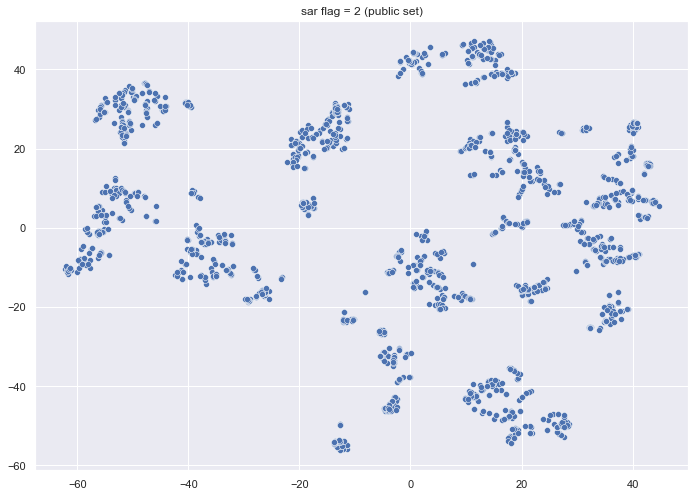

In [252]:
sar_df = dataset.data_df[dataset.data_df['sar_flag']==1]
X_tr = sar_df[dataset.Feature_Dict['feature_all']]
pipePre = Pipeline([('sc', MinMaxScaler()), ('pca', PCA(n_components=0.9))]) 
pipeTsne = Pipeline([('tsne', TSNE())]) 
X_tr_pre = pipePre.fit_transform(X_tr.fillna(0))
X_embedded = pipeTsne.fit_transform(X_tr_pre)
palette = sns.color_palette("bright", 1)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
plt.title('sar flag = 1')
plt.show()

sar_df = dataset.data_df[dataset.data_df['sar_flag']==0]
sar_df = sar_df.sample(1500)
X_tr = sar_df[dataset.Feature_Dict['feature_all']]
pipePre = Pipeline([('sc', MinMaxScaler()), ('pca', PCA(n_components=0.9))]) 
pipeTsne = Pipeline([('tsne', TSNE())]) 
X_tr_pre = pipePre.fit_transform(X_tr.fillna(0))
X_embedded = pipeTsne.fit_transform(X_tr_pre)
palette = sns.color_palette("bright", 1)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
plt.title('sar flag = 0')
plt.show()

sar_df = dataset.data_df[dataset.data_df['sar_flag']==2]
X_tr = sar_df[dataset.Feature_Dict['feature_all']]
pipePre = Pipeline([('sc', MinMaxScaler()), ('pca', PCA(n_components=0.9))]) 
pipeTsne = Pipeline([('tsne', TSNE())]) 
X_tr_pre = pipePre.fit_transform(X_tr.fillna(0))
X_embedded = pipeTsne.fit_transform(X_tr_pre)
palette = sns.color_palette("bright", 1)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
plt.title('sar flag = 2 (public set)')
plt.show()

(1000, 6)

<AxesSubplot:>

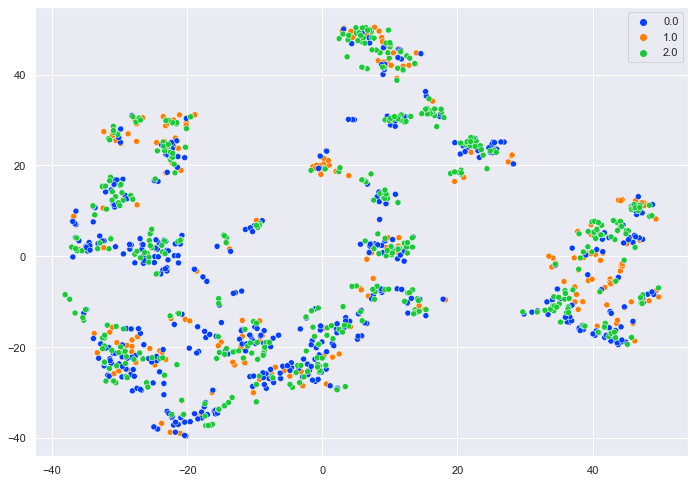

In [238]:
sar_df = dataset.data_df[dataset.data_df['sar_flag']==1]
pass_df = dataset.data_df[dataset.data_df['sar_flag']!=1]
X_tr = sar_df[dataset.Feature_Dict['feature_all']]
y_tr = sar_df['sar_flag']
X_val = pass_df[dataset.Feature_Dict['feature_all']]
y_val = pass_df['sar_flag']

pipePre = Pipeline([('sc', MinMaxScaler()), ('pca', PCA(n_components=0.9))]) 
pipeSpTom = imbPipeline([('sp', RandomUnderSampler(sampling_strategy={0:500, 2:500}))])
pipeTsne = Pipeline([('tsne', TSNE())]) 

X_tr_pre = pipePre.fit_transform(X_tr.fillna(0))
X_val_pre = pipePre.transform(X_val.fillna(0))
X_val_pre, y_val = pipeSpTom.fit_resample(X_val_pre, y_val)
X_tsne = np.concatenate([X_tr_pre,X_val_pre])
y_tsne = np.concatenate([y_tr,y_val])
#X_tsne = X_tr_pre
#y_tsne = y_tr

X_embedded = pipeTsne.fit_transform(X_tsne)
palette = sns.color_palette("bright", len(np.unique(y_tsne)))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_tsne, legend='full', palette=palette)



In [235]:
len(np.unique(y_tsne))

3

## Model Training

In [ ]:
X_tr, X_val, y_tr, y_val= train_test_split(dataset_Tr[featurePDAY_Diff], dataset_Tr[labelY].values, test_size=0.2, stratify=dataset_Tr[labelY])
X_tr, q95_dict, q5_dict = train_add_hat(X_tr, featurePDAY_Diff)
X_val = add_hat(X_val, featurePDAY_Diff, q95_dict, q5_dict)


In [ ]:

pipePre = Pipeline([('sc', MinMaxScaler()), ('pca', PCA(n_components=0.999))])
pipeSp = imbPipeline([('sp', RandomOverSampler(sampling_strategy=0.8))])

x_tr_ = pipePre.fit_transform(X_tr)
x_val_ = pipePre.transform(X_val.copy())
x_re, y_re = pipeSp.fit_resample(x_tr_, y_tr)
#x_re, y_re = x_tr_, y_tr
model = LogisticRegression()
model = model.fit(x_re, y_re)        
#tr_score
y_pred = model.predict(x_tr_)
y_predProb = model.predict_proba(x_tr_)
y_prob = np.max(y_predProb, axis=1)
y_sarProb = [x[1] for x in y_predProb]
tr_precision = get_recallN_Precision(y_sarProb, y_tr)
tr_acc = accuracy_score(y_tr, y_pred)
tr_recall = recall_score(y_tr, y_pred)

#val_score
y_predval = model.predict(x_val_)
y_predProb = model.predict_proba(x_val_)
y_predProb = [x[1] for x in y_predProb]
precisionScore = get_recallN_Precision(y_predProb, y_val)
score_tuple = SCORE_TUPLE('PDA', 'minmax', 'smote', 'LR', '', precisionScore,0)
print(f'tr_acc: {tr_acc:.3f}, tr_precision:{tr_precision:.3f}, tr_recall:{tr_recall:.3f}')
print(score_tuple)


In [ ]:
X_tr, X_val, y_tr, y_val= train_test_split(dataset_Tr[featurePDA], dataset_Tr[labelY].values, test_size=0.2, stratify=dataset_Tr[labelY])

X_tr = X_tr[featurePDA]
X_val = X_val[featurePDA]
pipePre = Pipeline([('sc', MinMaxScaler()), ('pca', PCA(n_components=0.999999999))])
pipeSp = imbPipeline([('sp', SMOTE())])

x_tr_ = pipePre.fit_transform(X_tr)
x_val_ = pipePre.transform(X_val.copy())
x_re, y_re = pipeSp.fit_resample(x_tr_, y_tr)
model = LogisticRegression(max_iter=30)
#model = SGDClassifier(loss='log', max_iter=10)
#model = XGBClassifier(n_estimators=10, use_label_encoder=False, tree_method='gpu_hist', gpu_id=0, eval_metric='logloss')
model = model.fit(x_re, y_re)        
#tr_score
y_pred = model.predict(x_tr_)
y_predProb = model.predict_proba(x_tr_)
y_prob = np.max(y_predProb, axis=1)
y_sarProb = [x[1] for x in y_predProb]
tr_precision = get_recallN_Precision(y_sarProb, y_tr)
tr_acc = accuracy_score(y_tr, y_pred)
tr_recall = recall_score(y_tr, y_pred)
print(f'tr_acc: {tr_acc:.3f}, tr_precision:{tr_precision:.3f}, tr_recall:{tr_recall:.3f}')

#val_score
y_predProb = model.predict_proba(x_val_)
y_predProb = [x[1] for x in y_predProb]
precisionScore = get_recallN_Precision(y_predProb, y_val)
score_tuple = SCORE_TUPLE(featureName, pipePreName, pipeSpName, modelName, i, precisionScore,0)
score_list.append(score_tuple)
print(score_tuple)



#過濾中間資料
if True:
    X_tr['y_sarProb']=y_sarProb
    X_tr['y_tr']=y_tr
    threshold = X_tr.sort_values(by='y_sarProb').iloc[int(len(X_tr)*0.95)]['y_sarProb']    
    X_tr_new = X_tr[(X_tr['y_sarProb']<threshold) | (X_tr['y_tr']==1)]
    y_tr_new = X_tr_new['y_tr'].values
    del X_tr_new['y_sarProb']
    del X_tr_new['y_tr']
    del X_tr['y_sarProb']
    del X_tr['y_tr']
else:
    X_tr_new = X_tr.copy()
    
x_tr_new = pipePre.fit_transform(X_tr_new)
x_val_ = pipePre.transform(X_val.copy())
x_re, y_re = pipeSp.fit_resample(x_tr_new, y_tr_new)
model = LogisticRegression()
#model = SGDClassifier(loss='log')
#model = XGBClassifier(use_label_encoder=False, tree_method='gpu_hist', gpu_id=0, eval_metric='logloss')
model = model.fit(x_re, y_re)        

y_pred = model.predict(x_tr_new)
y_predProb = model.predict_proba(x_tr_new)
y_prob = np.max(y_predProb, axis=1)
y_sarProb = [x[1] for x in y_predProb]
tr_precision = get_recallN_Precision(y_sarProb, y_tr_new)
tr_acc = accuracy_score(y_tr_new, y_pred)
tr_recall = recall_score(y_tr_new, y_pred)


#val_score
y_predProb = model.predict_proba(x_val_)
y_predProb = [x[1] for x in y_predProb]
precisionScore = get_recallN_Precision(y_predProb, y_val)
score_tuple = SCORE_TUPLE(featureName, pipePreName, pipeSpName, modelName, i, precisionScore,0)
score_list.append(score_tuple)
print(score_tuple, f'-- shape:{X_tr.shape}->{X_tr_new.shape}->{x_tr_new.shape}->{x_re.shape}')
print(f'tr_acc: {tr_acc:.3f}, tr_precision:{tr_precision:.3f}, tr_recall:{tr_recall:.3f}')


## Hyperparameter Tuning

In [ ]:
score_list = []
Y = dataset_Tr[labelY]
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=43)
skf.get_n_splits(dataset_Tr,Y)
for i, (tr_idx, val_idx) in enumerate(skf.split(dataset_Tr, Y)):
    predProb_list4 = []
    for featureX, featureName in feature_list:
        X_tr, X_val = dataset_Tr[featureX].iloc[tr_idx], dataset_Tr[featureX].iloc[val_idx]
        y_tr, y_val = Y.iloc[tr_idx], Y.iloc[val_idx]
        predProb_list3 = []
        for pipePre, pipePreName in pipe_list:
            predProb_list2 = []
            for pipeSp, pipeSpName in sp_list:
                predProb_list1 = []
                for model, modelName in model_list:
                    startTime = time.time() 
                    #preprocess
                    x_tr_ = X_tr.copy()
                    x_val_ = X_val.copy()
                    x_tr_ = pipePre.fit_transform(x_tr_)
                    x_val_ = pipePre.transform(x_val_)
                    x_re, y_re = pipeSp.fit_resample(x_tr_, y_tr)
                    model = model.fit(x_re, y_re)        
                    
                    #tr_score
                    y_pred = model.predict(x_tr_)
                    y_predProb = model.predict_proba(x_tr_)
                    y_predProb = [x[1] for x in y_predProb]
                    tr_precision = get_recallN_Precision(y_predProb, y_tr)
                    tr_acc = accuracy_score(y_tr, y_pred)
                    tr_recall = recall_score(y_tr, y_pred)
                    
                    #val score
                    y_predProb = model.predict_proba(x_val_)
                    y_predProb = [x[1] for x in y_predProb]
                    precisionScore = get_recallN_Precision(y_predProb, y_val)
                    t=time.time()-startTime
                    score_tuple = SCORE_TUPLE(featureName, pipePreName, pipeSpName, modelName, i, precisionScore, t)
                    score_list.append(score_tuple)
                    predProb_list1.append(y_predProb)
                    predProb_list2.append(y_predProb)
                    predProb_list3.append(y_predProb)
                    predProb_list4.append(y_predProb)
                    print(score_tuple)
                    print(f'-- shape:{X_tr.shape}->{x_tr_.shape}, time:{t:.1f}, ts score:{precisionScore:.4f}')
                    print(f'-- tr_acc: {tr_acc:.2f}, tr_precision:{tr_precision:.4f}, tr_recall:{tr_recall:.3f}')

                precisionScore = get_recallN_Precision(np.mean(predProb_list1, axis=0), y_val)
                score_list.append(SCORE_TUPLE(featureName, pipePreName, pipeSpName, 'ensemble', i, precisionScore, t))
            precisionScore = get_recallN_Precision(np.mean(predProb_list2, axis=0), y_val)
            score_list.append(SCORE_TUPLE(featureName, pipePreName, 'ensemble', 'ensemble', i, precisionScore, t))
        precisionScore = get_recallN_Precision(np.mean(predProb_list3, axis=0), y_val)
        score_list.append(SCORE_TUPLE(featureName, 'ensemble', 'ensemble', 'ensemble', i, precisionScore, t))
    precisionScore = get_recallN_Precision(np.mean(predProb_list4, axis=0), y_val)
    score_list.append(SCORE_TUPLE('ensemble', 'ensemble', 'ensemble', 'ensemble', i, precisionScore, t))        
                
                
score_df = pd.DataFrame(score_list)
score_df.sort_values('precision', ascending=False, inplace=True)
#joblib.dump(score_df, 'model_log/score_df.pkl')                



In [ ]:
score_df

In [ ]:

#display(score_df.sort_values('precision', ascending=False))
display(score_df.groupby(['feature'])['precision'].mean().to_frame().sort_values('precision', ascending=False))
#display(score_df.groupby(['model','iter'])['precision'].max().to_frame())
#display(score_df.groupby(['iter','model'])['precision'].max().to_frame())

In [ ]:
display(score_df.groupby('feature')['precision'].mean().to_frame().sort_values('precision', ascending=False))
display(score_df.groupby('sampling')['precision'].mean().to_frame().sort_values('precision', ascending=False))
display(score_df.groupby('model')['precision'].mean().to_frame().sort_values('precision', ascending=False))
display(score_df.groupby('iter')['precision'].mean().to_frame().sort_values('precision', ascending=False))

In [ ]:
display(score_df[score_df['model']=='LogisticRegression'].groupby('sampling')['precision'].mean().to_frame().sort_values('precision', ascending=False))
display(score_df[score_df['model']=='LogisticRegression'].groupby('feature')['precision'].mean().to_frame().sort_values('precision', ascending=False))
display(score_df[score_df['model']=='LogisticRegression'].groupby('model')['precision'].mean().to_frame().sort_values('precision', ascending=False))
display(score_df[score_df['model']=='LogisticRegression'].groupby('iter')['precision'].mean().to_frame().sort_values('precision', ascending=False))


In [ ]:
Parallel?
